In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Polygon, Patch, Rectangle
import matplotlib.font_manager as fm
font_path = '/users/wanglikun/.local/share/fonts/arial.ttf'  
fm.fontManager.addfont(font_path)                            
arial_name = fm.FontProperties(fname=font_path).get_name()  
plt.rcParams['font.family'] = [arial_name]
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv("dataset/data_fin.csv")

In [3]:
df_test = data[data["split"] == "test"].copy()
prob_cols = ["prob_OL", "prob_PE", "prob_PX", "prob_SU", "prob_SI", "prob_CA"]
df_avg_probs = df_test.groupby("index")[prob_cols].mean()
df_avg_probs["pred"] = df_avg_probs.idxmax(axis=1).str.replace("prob_", "")
true_map = df_test.groupby("index")["true"].first()
df_avg = df_avg_probs.join(true_map).reset_index()[["index", "true", "pred"]]
df_trainvalid = data[(data["split"].isin(["train", "valid"])) & (data["run"] == 1)][["index", "true", "pred"]].copy()
new_data = pd.concat([df_trainvalid, df_avg], ignore_index=True)
new_data = new_data.sort_values(by="index").reset_index(drop=True)

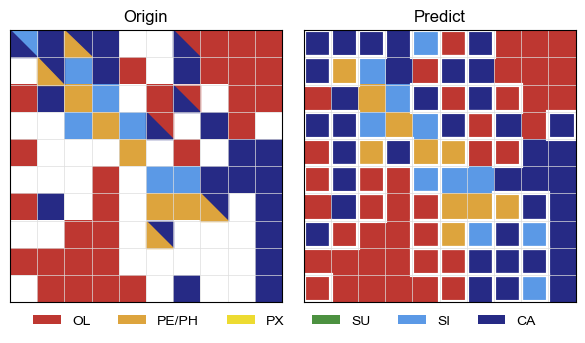

In [4]:
colors = {
    "OL": "#BE3731",
    "PE": "#DDA43D",
    "PX": "#EDDB31",
    "SU": "#4C9140",
    "SI": "#5B99E6",
    "CA": "#262A85",
}

def norm_str(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    return s.upper()

def is_multi_label(s):
    if s is None:
        return False
    return "/" in s  

def serpentine_rc(idx, n_cols=10):
    r = idx // n_cols
    c = idx % n_cols
    if r % 2 == 1:
        c = (n_cols - 1) - c
    return r, c

def plot_grid_B(ax, grid, title):
    n_rows, n_cols = len(grid), len(grid[0])
    rgba = np.array([[to_rgba(col) for col in row] for row in grid])
    ax.imshow(rgba, aspect="equal")
    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="#DDDDDD", linewidth=0.5)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_title(title, fontsize=12)

def make_grid_A(df, n_rows=10, n_cols=10, colors_map=None):
    WHITE = "#FFFFFF"
    grid = [[WHITE for _ in range(n_cols)] for __ in range(n_rows)]
    for i in range(len(df)):
        r, c = serpentine_rc(i, n_cols=n_cols)
        lab = df.iloc[i]["label_n"]
        if (lab is None) or (lab == "0") or is_multi_label(lab):
            grid[r][c] = WHITE
        else:
            grid[r][c] = colors_map.get(lab, WHITE)
    return grid

def make_grid_B(df, gridA, n_rows=10, n_cols=10, colors_map=None, valid_classes=None):
    WHITE = "#FFFFFF"
    gridB = [row[:] for row in gridA]  
    highlight = []
    for i in range(len(df)):
        r, c = serpentine_rc(i, n_cols=n_cols)
        lab = df.iloc[i]["label_n"]
        pred = df.iloc[i]["pred_n"]
        if gridA[r][c] == WHITE:
            if (lab is None) or (lab == "0") or is_multi_label(lab):
                if (pred in valid_classes) and (pred in colors_map):
                    gridB[r][c] = colors_map[pred]
                    highlight.append((r, c))
                else:
                    gridB[r][c] = WHITE
            else:
                gridB[r][c] = gridA[r][c]
    return gridB, highlight

def add_highlight_boxes(ax, highlight, edgecolor="red", linewidth=1.5):
    for r, c in highlight:
        ax.add_patch(Rectangle((c-0.5, r-0.5), 1, 1, fill=False,
                               edgecolor=edgecolor, linewidth=linewidth))

def make_grid_A(df, n_rows=10, n_cols=10, colors_map=None):
    WHITE = "#FFFFFF"
    grid = [[WHITE for _ in range(n_cols)] for __ in range(n_rows)]
    triangles = [] 

    for i in range(len(df)):
        r, c = serpentine_rc(i, n_cols=n_cols)
        lab = df.iloc[i]["label_n"]
        if lab is None or lab == "0" or lab.strip() == "":
            grid[r][c] = WHITE
            continue

        parts = [p.strip().upper() for p in str(lab).split("/") if p.strip()]
        parts = [p for p in parts if p in colors_map]

        if len(parts) == 0:
            grid[r][c] = WHITE
        elif len(parts) == 1:
            grid[r][c] = colors_map[parts[0]]
        else:
            grid[r][c] = WHITE 
            triangles.append((r, c, colors_map[parts[0]], colors_map[parts[1]]))

    return grid, triangles

def plot_grid_A(ax, grid, title, triangles=None):
    n_rows, n_cols = len(grid), len(grid[0])
    rgba = np.array([[to_rgba(col) for col in row] for row in grid])
    ax.imshow(rgba, aspect="equal")

    if triangles:
        for (r, c, col1, col2) in triangles:
            tri1 = Polygon([[c-0.5, r-0.5], [c+0.5, r-0.5], [c+0.5, r+0.5]],
                           closed=True, color=col1)
            tri2 = Polygon([[c-0.5, r-0.5], [c-0.5, r+0.5], [c+0.5, r+0.5]],
                           closed=True, color=col2)
            ax.add_patch(tri1)
            ax.add_patch(tri2)

    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="#DDDDDD", linewidth=0.5)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_title(title, fontsize=12)

num = 600
df100 = new_data.iloc[num:num + 100].copy()
df100["label_n"] = df100["true"].apply(norm_str)
df100["pred_n"]  = df100["pred"].apply(norm_str)

valid_classes = set(k.upper() for k in colors.keys())
WHITE = "#FFFFFF"

gridA, trianglesA = make_grid_A(df100, n_rows=10, n_cols=10, colors_map=colors)

gridB, highlight = make_grid_B(
    df=df100, gridA=gridA, n_rows=10, n_cols=10,
    colors_map=colors, valid_classes=valid_classes
)


fig2, axes2 = plt.subplots(1, 2, figsize=(8, 4))
plot_grid_A(axes2[0], gridA, "Origin", trianglesA)
plot_grid_B(axes2[1], gridB, "Predict")
add_highlight_boxes(axes2[1], highlight, edgecolor="white", linewidth=3)

plt.subplots_adjust(bottom=0.2, wspace=-0.1)
legend_handles = [
    Patch(facecolor=colors[k], edgecolor="none", label=("PE/PH" if k == "PE" else k))
    for k in ["OL","PE","PX","SU","SI","CA"]
]
plt.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.9, -0.00),
    ncol=6,
    frameon=False
)

for ax in axes2:
    ax.tick_params(axis='both', which='both', length=0)
    
plt.savefig("figure/5a.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

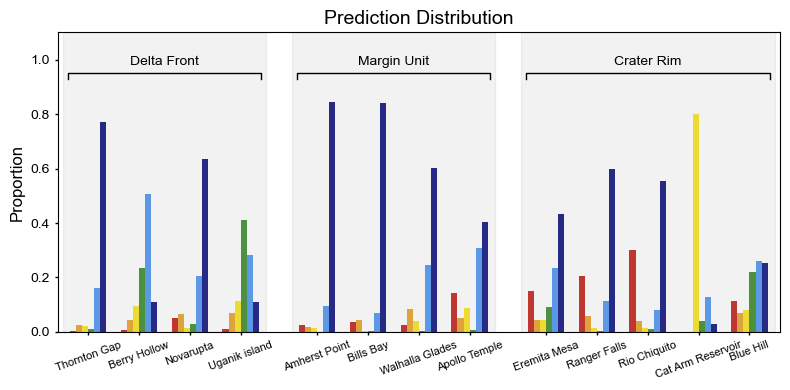

In [5]:
colors = {
    "OL": "#BE3731",
    "PE/PH": "#DDA43D",   
    "PX": "#EDDB31",
    "SU": "#4C9140",
    "SI": "#5B99E6",
    "CA": "#262A85",
}

ranges = [
    (4600,5000), (5100,5700), (5900,6200), (6400,7200),
    (7200,7400), (7400,7600), (7800,8200), (8700,9400),
    (10000,10400), (10800,11000), (11000,11400), (11400,11500), (11600,11800)
]

group_labels = ["Thornton Gap", "Berry Hollow", "Novarupta","Uganik island", 
                "Amherst Point", "Bills Bay", "Walhalla Glades", "Apollo Temple", 
                "Eremita Mesa", "Ranger Falls", "Rio Chiquito", "Cat Arm Reservoir", "Blue Hill"
               ]
classes = list(colors.keys())

def count_by_class(df, classes):
    s = df["pred"].astype(str).str.replace(r"PE", "PE/PH", regex=True)
    return s.value_counts().reindex(classes, fill_value=0).values

counts_per_group = []
for a,b in ranges:
    sub = new_data.iloc[a:b]
    counts_per_group.append(count_by_class(sub, classes))
counts_per_group = np.array(counts_per_group)   

n_classes = len(classes)
width = min(0.8 / n_classes, 0.12)  
n_groups = len(group_labels)
x_base = np.arange(n_groups, dtype=float)

gap1 = 0.5  
gap2 = 0.5 

x_pos = x_base.copy()
x_pos[4:] += gap1
x_pos[8:] += gap2

plt.figure(figsize=(max(8, n_groups*0.55), 4))

for j, cls in enumerate(classes):
    heights = counts_per_group[:, j] / counts_per_group.sum(axis=1)
    offset = (j - (n_classes-1)/2) * width
    plt.bar(x_pos  + offset, heights, width=width, color=colors[cls], label=cls)

plt.yticks(fontsize=10)
plt.xticks(x_pos, group_labels, fontsize=8, rotation = 20)
plt.xlim(x_pos[0] - 0.6, x_pos[-1] + 0.6)
plt.ylim(0,1.1)
plt.ylabel("Proportion", fontsize=12)
plt.title("Prediction Distribution", fontsize=14)
plt.tick_params(axis='both', width=1, length=2)

x0, x1 = x_pos[0] - 0.4, x_pos[3] + 0.4  
y = plt.ylim()[1]-0.15         
plt.plot([x0, x0, x1, x1], [y-0.02, y, y, y-0.02], color='black', lw=1.0)
plt.text((x0+x1)/2, y + 0.02, "Delta Front", ha='center', va='bottom', fontsize=10)

x0, x1 = x_pos[4] - 0.4, x_pos[7] + 0.4  
y = plt.ylim()[1]-0.15        
plt.plot([x0, x0, x1, x1], [y-0.02, y, y, y-0.02], color='black', lw=1.0)
plt.text((x0+x1)/2, y + 0.02, "Margin Unit", ha='center', va='bottom', fontsize=10)

x0, x1 = x_pos[8] - 0.4, x_pos[12] + 0.4  
y = plt.ylim()[1]-0.15        
plt.plot([x0, x0, x1, x1], [y-0.02, y, y, y-0.02], color='black', lw=1.0)
plt.text((x0+x1)/2, y + 0.02, "Crater Rim", ha='center', va='bottom', fontsize=10)

ax = plt.gca()
ax.axvspan(x_pos[0]-0.5, x_pos[3]+0.5, color='black', alpha=0.05, zorder=0)
ax.axvspan(x_pos[4]-0.5, x_pos[7]+0.5, color='black', alpha=0.05, zorder=0)
ax.axvspan(x_pos[8]-0.5, x_pos[12]+0.5, color='black', alpha=0.05, zorder=0)

plt.tight_layout()
plt.savefig("figure/5b.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()